# Prediccion del indice S&P 500 mediante XGBOOST y el modelo GARCH

In [1]:
# base
import pandas as pd
import numpy as np
import math
import datetime
import datetime as dt
import statsmodels.api as sms


# importacion datos financieros
import yfinance as yf

#metricas de evaluacion 

from arch.unitroot import PhillipsPerron , KPSS , ADF
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Graficas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# Prediccion modelos GARCH
from pmdarima import auto_arima
import arch
from arch import arch_model

# Prediccion modelo XGBOOST
import xgboost as xgb


# Lectura de datos

In [2]:
data = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4773040000


In [3]:
data = data.rename(columns=str.lower)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595 entries, 2021-01-04 to 2023-05-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       595 non-null    float64
 1   high       595 non-null    float64
 2   low        595 non-null    float64
 3   close      595 non-null    float64
 4   adj close  595 non-null    float64
 5   volume     595 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 32.5 KB


In [4]:
data['time'] = data.index

In [6]:
retornos = data[['close']].pct_change().dropna() * 100
retornos.head()

,close
Date,
2021-01-05,0.708260
2021-01-06,0.570984
2021-01-07,1.484740
2021-01-08,0.549186
2021-01-11,-0.655475


In [7]:
# media rendimientos diarios
retornos.mean()

close    0.025795
dtype: float64

In [11]:
# grafica de los retornos
close_price = retornos
rendimiento_acum_dia = close_price/close_price.iloc[0,:]
fig = px.line(rendimiento_acum_dia.iloc[:,:])
fig.update_layout(title_text='Redimiento acumulado diario S&P 500')
fig.show()

In [13]:
# volatilidad diaria
daily_volatility = retornos.values.std()
daily_volatility

1.1875247108327247

In [14]:
monthly_volatility = math.sqrt(21)*daily_volatility # 21 porque hay 21 dias habiles en el mes
monthly_volatility

5.441921877021506

<AxesSubplot:title={'center':'Rtornos diarios'}, xlabel='Date'>

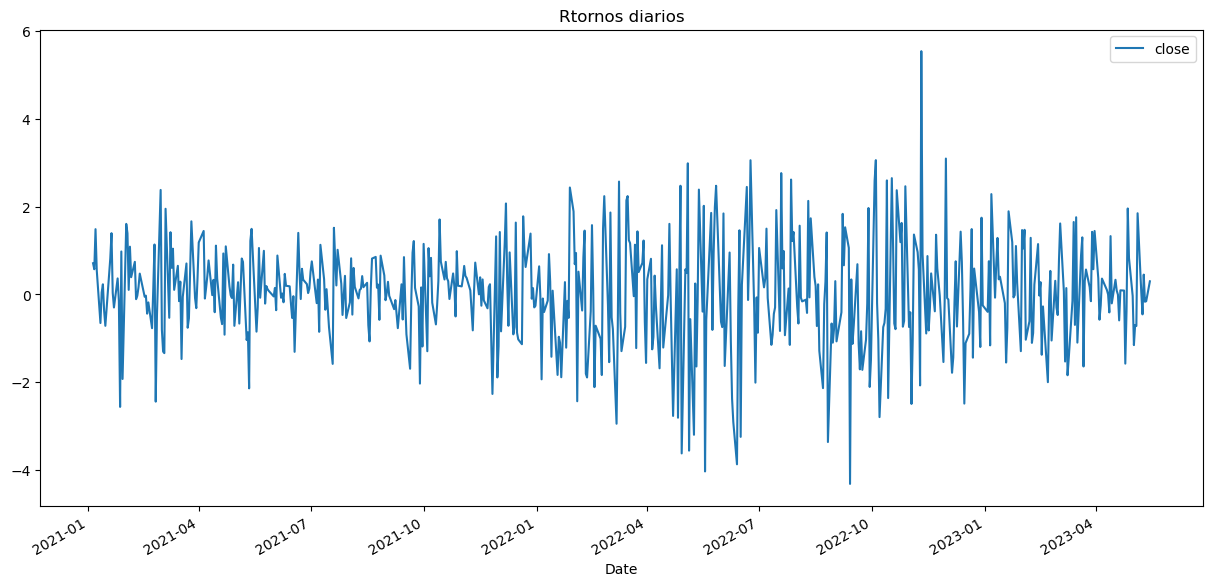

In [15]:
# retornos diarios sin acumulado
retornos.plot(figsize=(15,7),title='Rtornos diarios')

In [16]:
sns.histplot(data)

# Modelo GARCH 